In [1]:
import numpy as np
import matplotlib.pyplot as plt
from SARA_cornell_funcs import *
from edge_finder import *
from cookb_signalsmooth import *
import os
import glob
import sys
import cv2
import json
from WaferMapper import WaferMap
import matplotlib.backends.backend_pdf as PDF_saver

In [2]:
#all FPs for the 3 techniques
MatSysName = '18CIT49586_LaMnOx_take6_newCamera'
ptim = '/home/vandover/Documents/Data/18CIT49586_LaMnOx_retake/Take6/2020-06-02_Images/'
ptImgMirror = '/home/vandover/Documents/Data/18CIT49586_LaMnOx_retake/Take6/2020-06-02_Images/Mirror/2020-06-02_Mirror.bmp'
ptsp_raw = '/home/vandover/Documents/Data/18CIT49586_LaMnOx_retake/Take6/Spectroscopy/'
ptsp_m = '/home/vandover/Documents/Data/18CIT49586_LaMnOx_retake/Take6/Spectroscopy/Mirror/mirror_00.csv'
ptsp_b = '/home/vandover/Documents/Data/18CIT49586_LaMnOx_retake/Take6/Spectroscopy/Blank/blank_00.csv'
pth5 = '/home/vandover/Documents/Data/18CIT49586_LaMnOx_retake/LaMnOx_18CIT49586_rerun_all_oned.h5'
OptDict = FpDict(ptim,ftype='.bmp')
SpecDict = FpDict(ptsp_raw,ftype='.csv')
XrdDict = FpDict(pth5,Xrays=True)

# PCC analysis

tau_3000_T_1175
(500, 1280)


/home/vandover/.local/lib/python3.6/site-packages/matplotlib/_constrained_layout.py:226: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  warnings.warn('constrained_layout not applied.  At least '


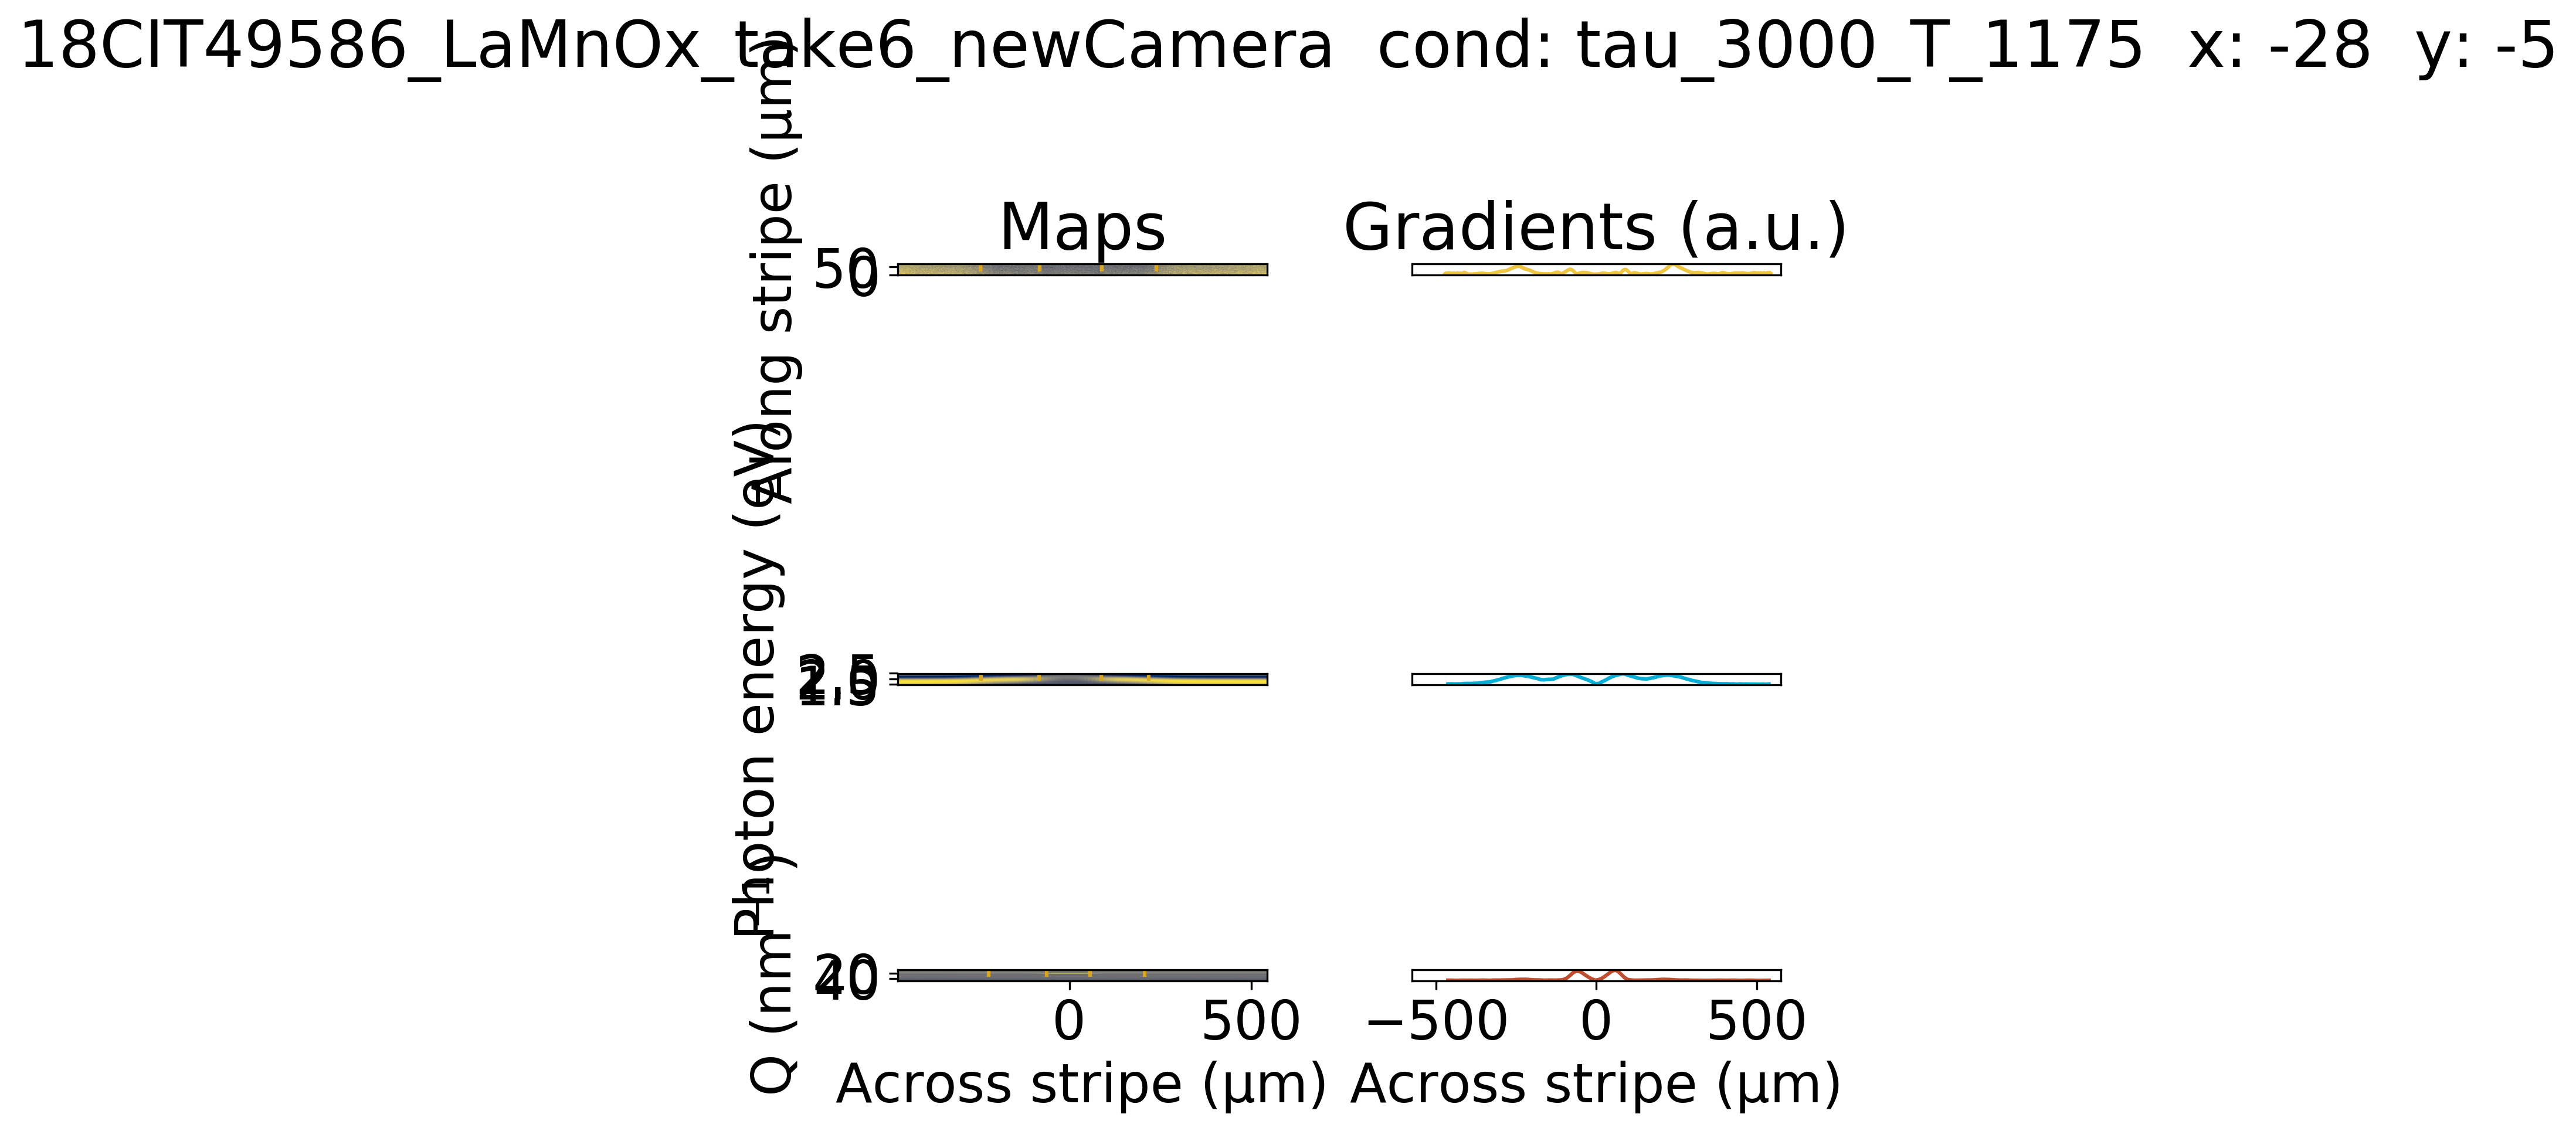

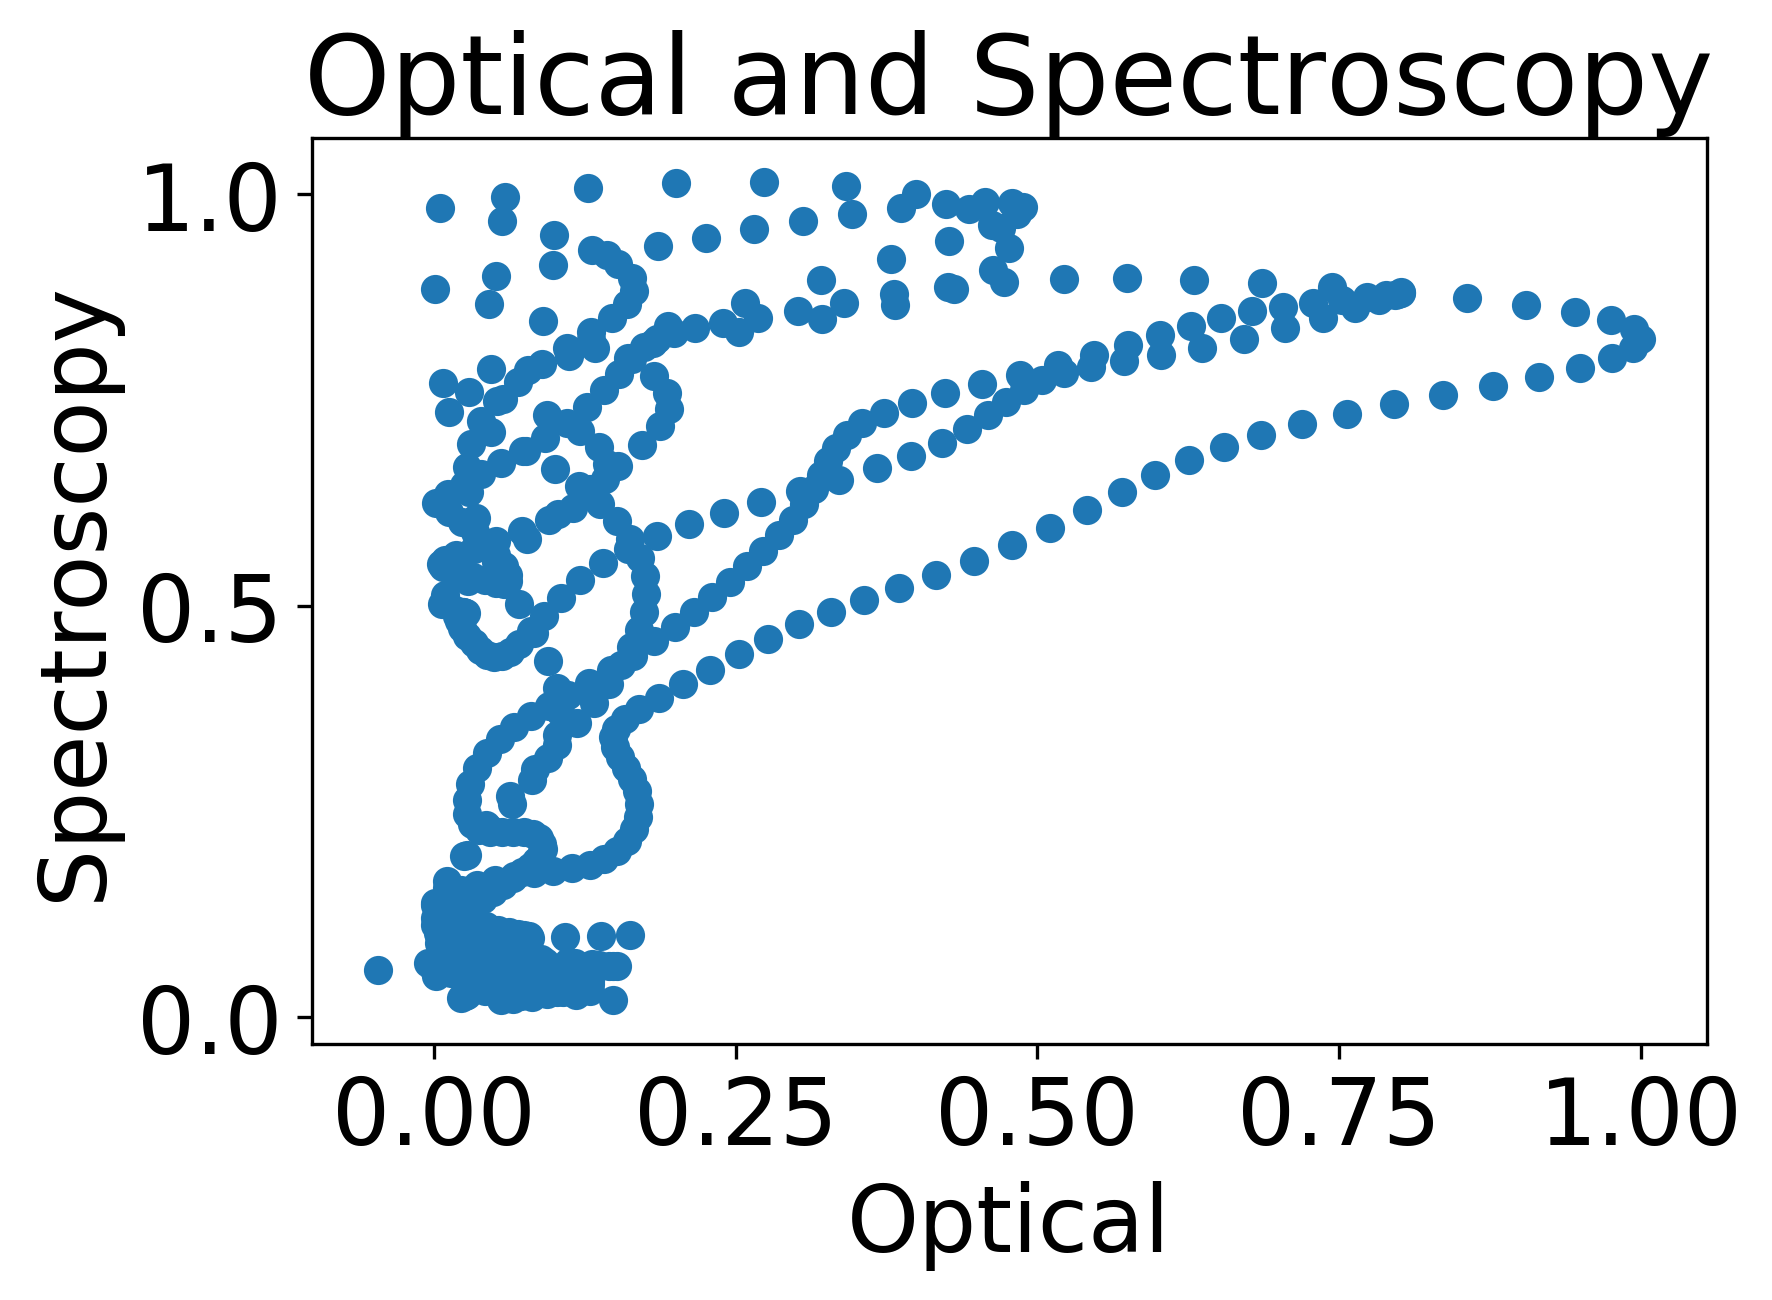

0.631
0.561


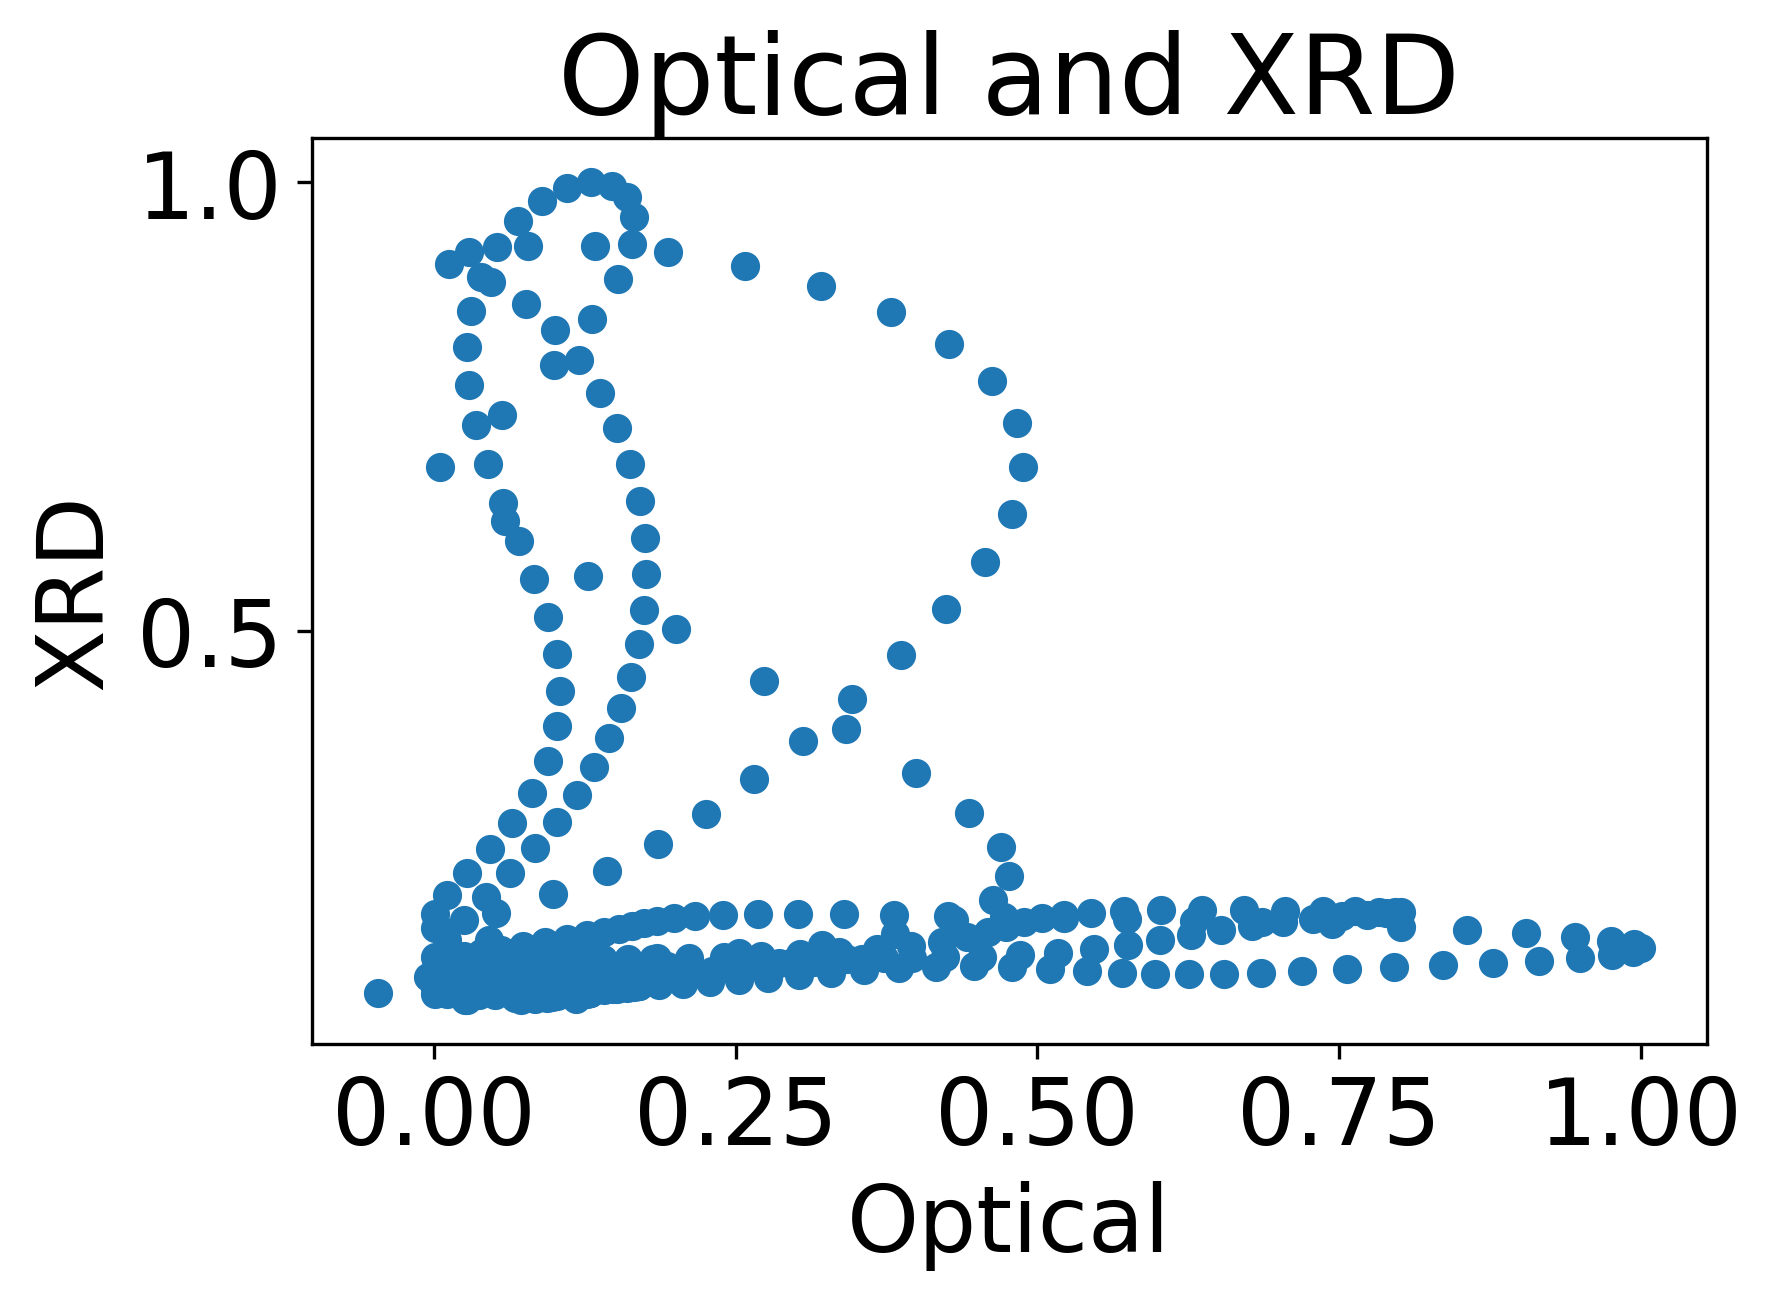

0.054
0.399


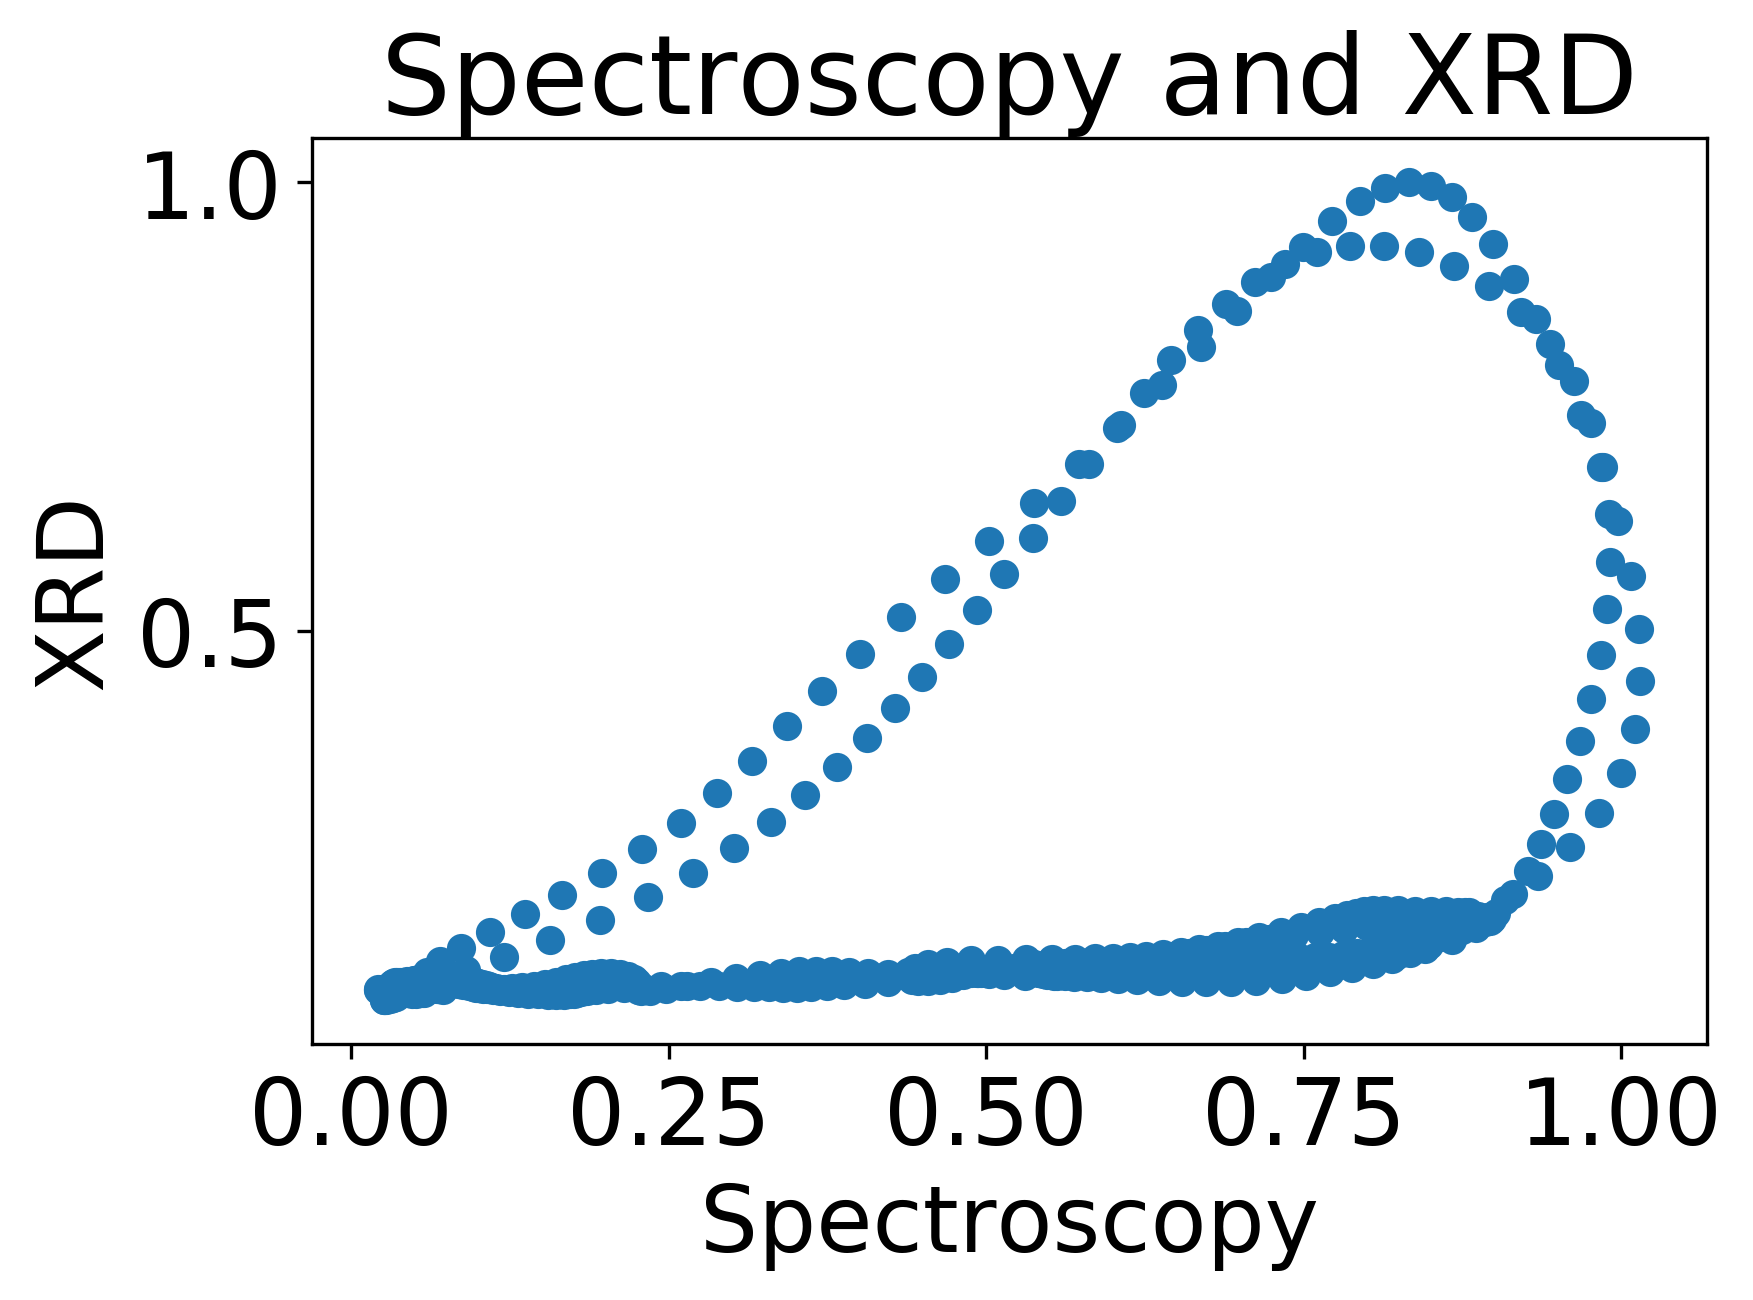

0.462
0.804


In [15]:
PC = {}
Okeys = dwellsort(list(OptDict))
Xkeys = dwellsort(list(XrdDict))
shiftol = 51
basepath = '/home/vandover/Documents/Data/18CIT49586_LaMnOx_retake/Take6/'

# instantiating the pdf to be made. ALL pdf lines must be enabled. uncomment this line if desired
# pdf = PDF_saver.PdfPages(basepath+MatSysName+'_3-Technique-Anaylsis.pdf')
#yellow,red,green,blue,mint
colors = ['#EEC643','#BF4E30','#44BBA4','#06AED5','#ACFCD9']

# test = [17,42,108,330,450,600]

test = [['tau_500_T_1025']]
# for idx in test:
# for key in ['tau_700_T_900','tau_400_T_900','tau_1000_T_1075','tau_8000_T_1250']:
#     idx = 0
for idx in np.arange(len(Okeys))[-30:-29]:
    key = Okeys[idx]
    key =  'tau_3000_T_1175'
    s = TechStripe()
    #Have to instantiate the data with the proper paths to data, pixel sizes, etc. 
    PC[key] = {}
    TechNames = ['Optical','Spectroscopy','XRD']
    #occasionally the XRD keys and Spectroscopy or Optical keys are not QUITE the same
    #but when sorted by tau or T, will be properly paired up. hence the Okey Xkey distinction
    okey = Okeys[idx]
    xkey = Xkeys[idx]
    okey = key
    xkey = key
    
    xpos = OptDict[okey]['xpos']
    ypos = OptDict[okey]['ypos']
    print(okey)
#     print(xkey)
#     print('')
    
    #giving the stripe class the appropriate paths to the data
    s.fpo = OptDict[okey]['fp']
    s.fprs = SpecDict[okey]['fp']
    s.fpb = ptsp_b
    s.fpm = ptsp_m
    s.fpImM = ptImgMirror
    s.h5file = pth5
    s.O_pxs = 0.793
    s.omapcrop = (250,750)
    #making the technique maps
    s.Optmap(okey=okey,weights=[0.3,0.59,0.11],grayscale=True,Norm=False,crop=True)
    s.Specmap(okey=okey)
    s.Xraymap(xkey=xkey,dpath=s.h5file)
    
    #getting the pixel sizes or defining them here
    ops = s.O_pxs
    sps = s.S_pxs
    xps = s.X_pxs
    
    #converting wavelength to eV
    wlr = s.wl
    hc = 2.998*10**8*4.1357*10**-15
    eVr =  hc/(wlr*10**-9)
    Q = s.Q
    
    #calling on the appodized maps(400-800 nm) and Y-cropped omap
#     omap = ndimage.gaussian_filter(np.array(s.omap[:,:,1],dtype=float),(15,15))
    omap = s.omap
    smap = s.smap
    xmap = s.xmap

    
    #defining fourier smoothing criteria (needs to be the same SPATIAL distance smoothed over)
    sf_o = int(np.round(10/s.O_pxs))
    sf_s = 1
    sf_x = 1
    #the signals should be comprably smoothed so a fourier fileter of 3% total pixels is applied
    #the XRD gets a second modification which is a sharpen unsharpen filter. see the "sharpen_y"
    #filter in the edge finder code.
    print(omap.shape)
    omap = DustCollector(omap,binsize=5,exc_z=2,filt_crit=4,plotting=False)[0]
    omap1 = ndimage.gaussian_filter(omap,(sf_o,sf_o))
    xmap = ndimage.gaussian_filter(xmap,(sf_x,sf_x))
    xmap1 = sharpen_y(xmap,alpha=0.25,bf=[1,1],fbf=[0.0,0.8],plotting=False)
    
    #Gradients
    osig = np.average(omap1,axis=0)
    og = GenGrad(osig,bwind=200,exc_z=75,bound_avg=True,norm=True,plotting=False)
    sg = Grad(smap,bound_avg=True,norm=True)[0]
#     sg = Spectroscopy_Transiton_Finder(smap,Gpromfilt=0.05,h_cutoff=10,h_thresh=5,s_param=1,pix_siz=10)['gradient']
    xg = Grad(xmap1,bound_avg=True,norm=True)[0]

#     #Gradient test plot
#     fig,ax = plt.subplots(3,2)
#     ax[0,0].plot(og,'r')
#     ax[1,0].plot(sg,'g')
#     ax[2,0].plot(xg,'b')
#     ax[0,1].imshow(omap1,aspect='auto')
#     ax[1,1].imshow(smap,aspect='auto')
#     ax[2,1].imshow(xmap1,aspect='auto')
    
#     plt.show()
#     plt.close(fig)
    

    def h_filt(sig,h_cutoff,filt=3):
        a_sigma = abs((np.std(sig[0:h_cutoff])+np.std(sig[-h_cutoff:]))*0.5)
        a_mean = abs((np.mean(sig[0:h_cutoff])+np.mean(sig[-h_cutoff:]))*0.5)
        h_filt = filt*a_sigma + a_mean
#         print(max(sig))
#         print(h_filt)
        return h_filt
    
    otrs = signal.find_peaks(og,prominence=0.05,width=[0.001*len(og),0.25*len(og)],height=h_filt(og,150,filt=4))[0]
    strs = Spectroscopy_Transiton_Finder(smap,Gpromfilt=.02,h_thresh=3,h_cutoff=10,s_param=0.01,cond=key,plotting=False)['TR_idx']
    xtrs = signal.find_peaks(xg,prominence=0.02,width=[0.001*len(xg),0.25*len(xg)],height=h_filt(xg,15,filt=4))[0]


    
    # each technique spans a different anneal space. Each technique needs to be tailored accordingly.
    # For this sample, the x-ray maps span 1.5 mm, whereas the optical and spectroscopy are ~1.2 mm 
    # and 2.01 mm respectively. This will change depending on the material system, the zoom of the
    # optical camera, the space collected by the spectroscopy and that of the XRD. 
    
    #lateral space of each technique   
    ox = np.linspace(0,ops*(len(og)-1),len(og))
    sx = np.linspace(0,sps*(len(sg)-1),len(sg))
    xx = np.linspace(0,xps*(len(xg)-1),len(xg))    
    
    #centers
    oc = CenterFinding(og,sparam=20,plotting=False)
    sc = CenterFinding(sg,sparam=2,plotting=False)
    xc = CenterFinding(xg,sparam=2,plotting=False)
#     print(oc,sc,xc)
    
    #centering the anneal space around the center of the stripe
    ox = (ox-oc*ops)
    sx = (sx-sc*sps)
    xx = (xx-xc*xps)
    
    #correcting the Transition positions for origin shift and putting it in anneal space
    otrs = [ox[i] for i in otrs]  
    strs = [sx[i] for i in strs] 
    xtrs = [xx[i] for i in xtrs]

    # minmax of each technique
    minx = max(min(ox),min(sx),min(xx))
    maxx = min(max(ox),max(sx),max(xx))
#     print(minx,maxx)

    omap = omap[:,[(ox>=minx)&(ox<=maxx)][0]]
    smap = smap[:,[(sx>=minx)&(sx<=maxx)][0]]    
    xmap = xmap[:,[(xx>=minx)&(xx<=maxx)][0]]
    
    og = og[(ox>=minx)&(ox<=maxx)]
    sg = sg[(sx>=minx)&(sx<=maxx)]
    xg = xg[(xx>=minx)&(xx<=maxx)]
    
    ox = ox[(ox>=minx)&(ox<=maxx)]
    sx = sx[(sx>=minx)&(sx<=maxx)]
    xx = xx[(xx>=minx)&(xx<=maxx)]
    
    otrs = np.array(otrs)[(otrs>=minx) & (otrs<=maxx)] 
    strs = np.array(strs)[(strs>=minx) & (strs<=maxx)]
    xtrs = np.array(xtrs)[(xtrs>=minx) & (xtrs<=maxx)]
    
    
    #Pulling it all together
    TechPSs = [ops,sps,xps]
    TechGrads = [og,sg,xg]
    TechMaps = [omap,smap,xmap]
#     print(f'pixel sizes:{TechPSs}')
    
#     #Centering test plot
#     fig,ax = plt.subplots(3,1,sharex=True)
#     ax[0].plot(ox,og,'r')
#     ax[1].plot(sx,sg,'g')
#     ax[2].plot(xx,xg,'b')
#     for c in [0,1,2]:
#         ax[c].axvline(0,c='goldenrod')
#     ax[0].set_xlim(minx,maxx)
#     plt.show()
#     plt.close(fig)
    
    plotting=True
    if plotting:
        fig,ax = plt.subplots(3,2,figsize=(6.4,6.4),constrained_layout=True,dpi=300)
        fig.suptitle(f'{MatSysName}  cond: {key}  x: {xpos}  y: {ypos}')
        ax[0,0].imshow(omap,aspect='auto',cmap='cividis',extent=[minx,maxx,0,omap.shape[0]*ops])
        ax[1,0].imshow(smap,aspect='auto',cmap='cividis',extent=[minx,maxx,eVr[-1],eVr[0]],)
        ax[2,0].imshow(xmap,aspect='auto',cmap='cividis',extent=[minx,maxx,max(Q),min(Q)])

        ax[0,0].set_xticks([])
        ax[1,0].set_xticks([])
        ax[2,0].set_xlabel('Across stripe (\u03bcm)')
        ax[0,0].set_ylabel('Along stripe (\u03bcm)')
        ax[1,0].set_ylabel('Photon energy (eV)')
        ax[2,0].set_ylabel('Q (nm$^{-1})$')

    #     ax[0,0].set_xlim([0,800])
    #     ax[1,0].set_xlim([0,800])
    #     ax[2,0].set_xlim([-400,400])

        #rightern plot
        ax[0,1].plot(ox,og,c=colors[0])
        ax[1,1].plot(sx,sg,c=colors[3])
        ax[2,1].plot(xx,xg,c=colors[1])
        for tr in otrs:
            ax[0,0].axvline(tr,ymin=0.5,ymax=1,c='goldenrod')
        for tr in strs:
            ax[1,0].axvline(tr,ymin=0.5,ymax=1,c='goldenrod')
        for tr in xtrs:
            ax[2,0].axvline(tr,ymin=0.5,ymax=1,c='goldenrod')
        ax[0,1].set_xticks([])
        ax[1,1].set_xticks([])
        ax[2,1].set_xlabel('Across stripe (\u03bcm)')
        ax[0,1].set_xticks([])
        ax[1,1].set_xticks([])
        ax[0,1].set_xlim([-575,575])
        ax[1,1].set_xlim([-575,575])
        ax[2,1].set_xlim([-575,575])
        for yt in [0,1,2]:
            ax[yt,1].set_yticks([])

        ax[0,0].set_title('Maps')
        ax[0,1].set_title('Gradients (a.u.)')

        plt.show(fig)
#         plt.savefig(f'/home/vandover/Documents/Data/18CIT49586_LaMnOx_retake/Take6/pdf_imgs/{MatSysName}_{okey}.pdf')
        plt.close(fig)
    
    #Correlation code
    for adx,bdx in [(0,1),(0,2),(1,2)]:
    
        #loading in the technique pairs Opt:Spec, Opt:XRD, Spec:XRD
        a = TechGrads[adx]
        b = TechGrads[bdx]
        aps = TechPSs[adx]
        bps = TechPSs[bdx]
        aname = TechNames[adx]
        bname = TechNames[bdx]
    #         print(aname,bname)
    #         print(len(a),len(b))

        #Turning the gradients into  splines for the optimized correlation functions
        afxn,anormgrad,axgrad,acidx = GradSigNormAndCenter(signal=a,pixelsize=aps,CFon=True,plotting=False)
        bfxn,bnormgrad,bxgrad,bcidx = GradSigNormAndCenter(signal=b,pixelsize=bps,CFon=True,plotting=False)
        
        # finding the shared space for the two techniques to be compared
        maxx_corr = min(max(axgrad),max(bxgrad)) 
        sharedx = np.linspace(0,maxx_corr,501)
        
        
        # optimizes the Gradients over the shared space within some distance from eachother
        xshift, PC0, newx, nafxn, nbfxn = bestPC(sharedx,bfxn,afxn,shift_tol=shiftol,plotting=False)
        PC[key][f'PC for {aname} and {bname}'] = PC0
        PC[key][f'SCC for {aname} and {bname}'] = scipy.stats.spearmanr(a=afxn(sharedx),b=bfxn(sharedx))
        
#         fig,ax = plt.subplots(1,1,dpi=300)
#         ax.plot(newx,nafxn(newx),c=colors[0])
#         ax.plot(newx,nbfxn(newx),c=colors[1])
#         ax.set_xlabel('Anneal space in \u03BCm')
#         ax.set_ylabel('Normalized gradient (a.u.)')
#         ax.set_title(f'Optimized Gradient between {aname} and {bname}')
#         textstr = f'PCC = {np.round(PC0,decimals=3)}'
#         ax.text(0.9, 0.9, textstr)
#         plt.show(fig)
#         plt.close(fig)
#         string = '\n'.join([f'PCC: {str(PC[key][f'PC for {aname} and {bname}'])}',
#             f'SCC: {str(np.round(PC[key][f'SCC for {aname} and {bname}'][0],decimals=3))}'])
        plt.figure(dpi=300)
        plt.scatter(afxn(sharedx),bfxn(sharedx))
        plt.title(f'{aname} and {bname}')
        plt.xlabel(aname)
        plt.ylabel(bname)
#         plt.text(0.9,0.1,string)
        plt.show()
        print(PC[key][f'PC for {aname} and {bname}'])
        print(np.round(PC[key][f'SCC for {aname} and {bname}'][0],decimals=3))
        plt.close()
#         print('pearsons')
#         print(scipy.stats.pearsonr(afxn(sharedx),bfxn(sharedx))[0])
#         print('')
        
#         print('spearmans')
#         print(scipy.stats.spearmanr(a=afxn(sharedx),b=bfxn(sharedx))[0])
        
# #         print(PC0)
#         print('')
#     textstr = '\n'.join(list(PC[key]))
#     plt.show(fig)
#     plt.close(fig)
# PCCfp = f'/home/vandover/Documents/Data/18CIT49586_LaMnOx_retake/Take6/{MatSysName}.json'
# with open(PCCfp,'w') as json_file:
#     json.dump(PC,json_file)

In [ ]:
s.wl

In [ ]:
#making the pdf from the images
import PyPDF2
fp2pdfs = '/home/vandover/Documents/Data/18CIT49586_LaMnOx_retake/Take6/pdf_imgs/'
fps = list(glob.glob(fp2pdfs+'*.pdf'))
merger = PyPDF2.PdfFileMerger()

for key in Okeys:
    file = fp2pdfs+f'18CIT49586_LaMnOx_take6_newCamera_{key}.pdf'
    merger.append(file)
    
merger.write(f'/home/vandover/Desktop/{MatSysName}.pdf')

In [ ]:
PCCfp = f'/home/vandover/Documents/Data/18CIT49586_LaMnOx_retake/Take6/{MatSysName}.json'
with open(PCCfp,'w') as json_file:
    json.dump(PC,json_file)

In [ ]:
Okeys = list(dwellsort(OptDict))
mir = cv2.imread(ptImgMirror)
plt.imshow(mir)
plt.show()
plt.close()
for i in test:
    key = Okeys[i]
    im = cv2.imread(OptDict[key]['fp'])
    gs = np.average(im,axis=2)
    ngs = np.average(im/mir,axis=2)
    fig,ax = plt.subplots(4,1,dpi=150,sharex=True)
    ax[0].imshow(im)
    ax[1].imshow(gs)
    ax[2].imshow(im/mir)
    ax[3].imshow(ngs)
    
    plt.show()
    plt.close()

In [ ]:
def LinearBS(s):
    slope = (s[-1]-s[0])/len(s)
    bkg = np.arange(len(s))*slope
    news = s-bkg
    return news

# def DustCollector(im,binwidth=20):
#     nbins = int(np.floor(im.shape[1]/binwidth))
#     print(nbins)
# return nbins

im = cv2.imread(OptDict[key]['fp'])
mir = cv2.imread(ptImgMirror)
cs = ['r','g','b']
Gs = []
normSig = []

norm = im/mir
norm = np.average(norm,axis=2)
def DustCollector(im,binsize=20,exc_z=1,filt_crit=3,plotting=True):
    """DustCollector filters the image"""
    nbins = int(np.floor(im.shape[0]/binsize))
    emeans = []
    estds = []
    ROIs = []
    for i in np.linspace(exc_z,nbins-exc_z,nbins-2*exc_z,dtype=int):
    #     print(i)
        ROI_lower = i*binsize
        ROI_upper = (i+1)*binsize
        ROI_avg = np.average(norm[ROI_lower:ROI_upper],axis=0)
        ROIs.append(ROI_avg)

        ensemble_mean = 0.5*(np.mean(norm[:ROI_lower],axis=0) + np.mean(norm[ROI_upper:],axis=0))
        ensemble_std = 0.5*(np.std(norm[:ROI_lower],axis=0) + np.std(norm[ROI_upper:],axis=0))
        emeans.append(ensemble_mean)
        estds.append(ensemble_std)

    ROIs = np.array(ROIs,dtype=float)
    emeans = np.array(emeans,dtype=float)
    estds = np.array(estds,dtype=float)
    diffs = []
    good = []
    bad = []
    for idx in np.arange(len(ROIs)):
        diff = abs(ROIs[idx]-emeans[idx])
        diffs.append(diff)
        if np.any(diff>filt_crit*estds[idx]):
            bad.append(ROIs[idx])
        else:
            good.append(ROIs[idx])
    good = np.array(good)
    bad = np.array(bad)
    diffs = np.array(diffs)
    if plotting:
        fig,ax = plt.subplots(4,1,figsize = (4,12))
        ax[0].imshow(ROIs,aspect='auto')
        ax[1].imshow(diffs,aspect='auto',label='all')
        ax[2].imshow(good,aspect='auto',label='good')
        ax[3].imshow(bad,aspect='auto',label='bad')
        plt.show()
        plt.close(fig)

        fig,ax = plt.subplots(3,1)
        ax[0].plot(np.average(ROIs,axis=0))
        ax[1].plot(np.average(good,axis=0))
        ax[2].plot(np.average(bad,axis=0))
        plt.show()
        plt.close(fig)
        
    return good,bad,diffs

good,_,_=DustCollector(norm,binsize=15,exc_z=3,filt_crit=3,plotting=True)
good = LinearBS(np.average(good,axis=0))
good = ndimage.gaussian_filter1d(good,sf_o)

gradgood = np.gradient(good)
gradgood = np.sqrt(gradgood*gradgood)
plt.plot(good/max(good))
plt.plot(gradgood/max(gradgood))

In [ ]:
def CenterFinding(signal,sparam,window_len=0,filt=False,Failsafe=0.35,plotting=False):
    """Locate the center of a symmetric signal by using auto correlation.
    
    signal = (array) 1D array consisting of the signal
    sparam = (int) smoothing parameter for the signal to help locate the center
    filt = (bool) will apply a window around the center to help with local maxima
    window_len = (int) the filter window in pixels
    Failsafe = (float) a percentage of error allowed for the found center about the middle of the signal
    Plotting = (bool) Troubleshooting center finding
    
    """
    ssig = ndimage.gaussian_filter1d(signal,sparam)
    mid = int(0.5*len(ssig))
    if filt == True:
        corr = ndimage.correlate(ssig,ssig[::-1],mode='wrap')[(mid-window_len):(mid+window_len)]
    else:
        corr = ndimage.correlate(ssig,ssig[::-1],mode='wrap')
    center = (len(ssig))*0.5 + (np.argmax(corr)-(len(corr))*0.5)*0.5
    if (center > (0.5+Failsafe)*len(ssig)) or (center < Failsafe*len(ssig)):
        center = int(np.round(0.5*len(ssig)))
    
    if plotting == True:
        plt.figure()
        plt.plot(signal,c='dodgerblue')
        plt.plot(ssig,c='goldenrod')
        plt.axvline(center,c='darkorchid')
        plt.show()
    return center    

# Script to scale and compare

In [ ]:
PC = {}
Okeys = dwellsort(list(OptDict))
Xkeys = dwellsort(list(XrdDict))
shiftol = 51
# wlr = wl[300:1300]
# hc = 2.998*10**8*4.1357*10**-15
# eVr =  hc/(wlr*10**-9)
s = TechStripe()
#Have to instantiate the data with the proper paths to data, pixel sizes, etc. 
# PC[key] = {}
TechNames = ['Optical','Spectroscopy','XRD']
#occasionally the XRD keys and Spectroscopy or Optical keys are not QUITE the same
#but when sorted by tau or T, will be properly paired up. hence the Okey Xkey distinction
idx = 600
okey = Okeys[idx]
xkey = Xkeys[idx]

#giving the stripe class the appropriate paths to the data
s.fpo = OptDict[okey]['fp']
s.fprs = SpecDict[okey]['fp']
s.fpb = ptsp_b
s.fpm = ptsp_m
s.h5file = pth5

#making the technique maps
s.Optmap(okey=okey,grayscale=True)
s.Specmap(okey=okey)
s.Xraymap(xkey=xkey,dpath=s.h5file)

#calling on the appodized functions
omap = s.omap
smap = s.smap
xmap = s.xmap

#getting the gradients and the technique map gradients
sg,sgmap = s.Grad(smap)
og,ogmap = s.Grad(omap)
xg,xgmap = s.Grad(xmap)

#defining filter criteria
sf_o = int(0.03*len(og))
sf_s = int(0.03*len(sg))
sf_x = int(0.03*len(xg))

#the signals should be comprably smoothed so a fourier fileter of 3% total pixels is applied
#the XRD gets a second modification which is a sharpen unsharpen filter. see the "sharpen_y"
#filter in the edge finder code.
omap = np.array([smooth(row,window_len=sf_o) for row in omap])
smap = np.array([smooth(row,window_len=sf_s) for row in smap])
xmap_sharp = sharpen_y(np.array([smooth(row,window_len=sf_x) for row in xmap]),bf=[1,1],alpha=1,fbf=[0.1,0],plotting=False)

#recalculating the gradients from the smoothed techniques vs. just smoothing
xg,xgmap = s.Grad(xmap_sharp)
og,ogmap = s.Grad(omap)
sg,sgmap = s.Grad(smap)

# each technique spans a different anneal space. Each technique needs to be tailored accordingly.
# For this sample, the x-ray maps span 1.5 mm, whereas the optical and spectroscopy are ~1.2 mm 
# and 2.01 mm respectively. This will change depending on the material system, the zoom of the
# optical camera, the space collected by the spectroscopy and that of the XRD. 

#getting the pixel sizes or defining them here
ops = s.O_pxs
sps = s.S_pxs
xps = s.X_pxs

#Anneal Space        
ox = np.linspace(0,ops*(len(og)-1),len(og))
sx = np.linspace(0,sps*(len(sg)-1),len(sg))
xx = np.linspace(0,xps*(len(xg)-1),len(xg))

#centers
oc = CenterFinding(og,1)
sc = CenterFinding(sg,1)
xc = CenterFinding(xg,1)

#centering the anneal space around the center
ox = (ox-oc*ops)
sx = (sx-sc*sps)
xx = (xx-xc*xps)

# minmax
minx = max(min(ox),min(sx),min(xx))
maxx = min(max(ox),max(sx),max(xx))


#Centering test plot
fig,ax = plt.subplots(3,1,sharex=True)
ax[0].plot(ox,og,'r')
ax[1].plot(sx,sg,'g')
ax[2].plot(xx,xg,'b')
for c in [0,1,2]:
    ax[c].axvline(0,c='goldenrod')
ax[0].set_xlim(minx,maxx)
plt.show()
plt.close(fig)

omap = omap[:,[(ox>=minx)&(ox<=maxx)][0]]
smap = smap[:,[(sx>=minx)&(sx<=maxx)][0]]    
xmap = xmap[:,[(xx>=minx)&(xx<=maxx)][0]]

ogmap = ogmap[:,[(ox>=minx)&(ox<=maxx)][0]]
sgmap = sgmap[:,[(sx>=minx)&(sx<=maxx)][0]]    
xgmap = xgmap[:,[(xx>=minx)&(xx<=maxx)][0]]

og = og[(ox>=minx)&(ox<=maxx)]
sg = sg[(sx>=minx)&(sx<=maxx)]
xg = xg[(xx>=minx)&(xx<=maxx)]


#Pulling it all together
TechPSs = [ops,sps,xps]
TechGrads = [og,sg,xg]
TechMaps = [omap,smap,xmap]
TechMapGrads = [ogmap,sgmap,xgmap]
   
fig,ax = plt.subplots(3,3,constrained_layout=True,figsize=(12,10))
ax[0,0].imshow(omap,aspect='auto')
ax[1,0].imshow(ogmap,aspect='auto')
ax[2,0].plot(og)

ax[0,1].imshow(smap,aspect='auto')
ax[1,1].imshow(sgmap,aspect='auto')
ax[2,1].plot(sg)

ax[0,2].imshow(xmap_sharp,aspect='auto')
ax[1,2].imshow(xgmap,aspect='auto')
ax[2,2].plot(xg)
plt.show()
plt.close(fig)

In [ ]:
PCCfp = f'/home/vandover/Documents/Data/18CIT49586_LaMnOx_retake/Take5/{MatSysName}.json'
with open(PCCfp,'w') as json_file:
    json.dump(PC,json_file)

In [ ]:
minx,maxx

# Fijures

NameError: name 'omap' is not defined

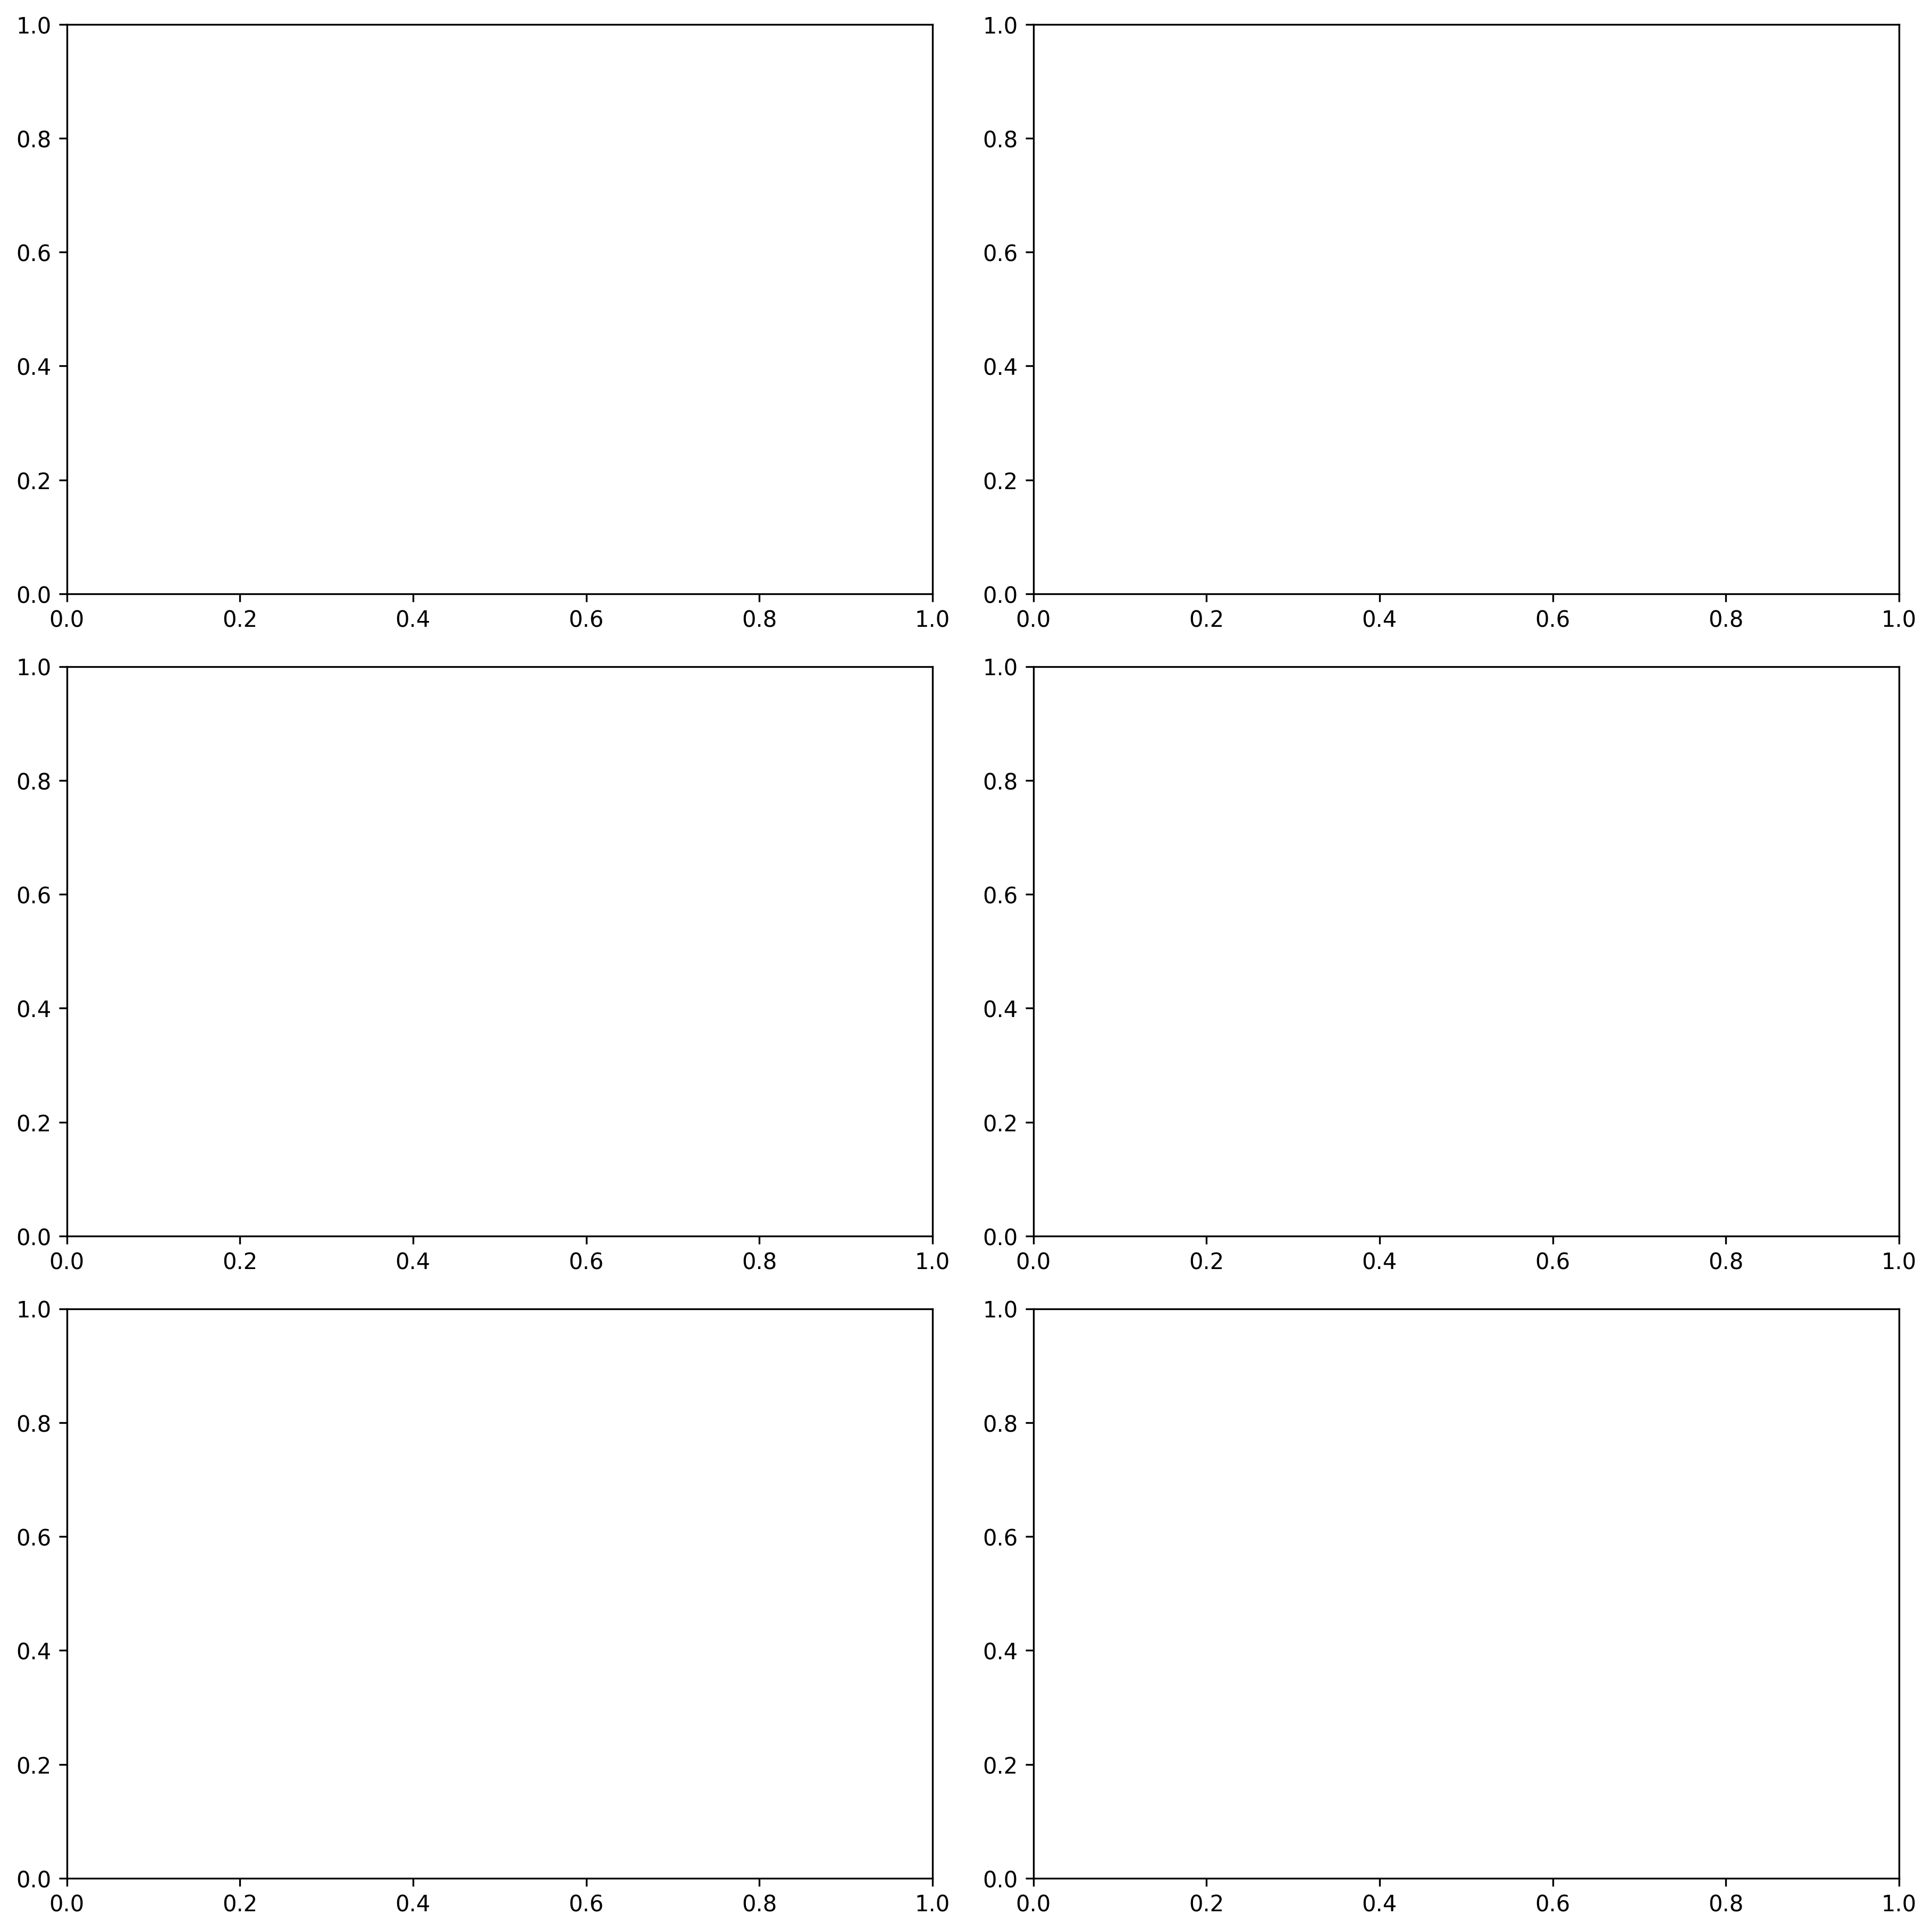

In [4]:
figsavepath = '/home/vandover/Desktop/2020-07-06_FigurePlots/'
date = '2020-08-12'
plotting=True
# figim = s.Optmap(Norm=True,crop=True,grayscale=False,okey=key)

# fig,ax=plt.subplots(1,1,dpi=300,figsize=(9,6))
# im = figim[250:750,:,:]
# # print(im.shape)
# ax.imshow(im,aspect='auto',extent=[minx,maxx,0,im.shape[0]*ops])
# ax.set_xlim([-400,400])
# # ax.set_ylim([250*ops,750*ops])
# ax.set_xlabel('Across stripe (\u03bcm)')
# ax.set_ylabel('Along stripe (\u03bcm)')
# ax.set_title('Optical Micrograph')
# fig.savefig(figsavepath+f'{date}_{MatSysName}_OpticalMicrograph.pdf')
# fig.savefig(figsavepath+f'{date}_{MatSysName}_OpticalMicrograph.png',dpi=300)
# plt.show()
# plt.close(fig)

# #spectroscopy
# fig,ax=plt.subplots(1,1,dpi=300,figsize=(9,6))
# ax.imshow(smap,aspect='auto',cmap='cividis',extent=[minx,maxx,eVr[-1],eVr[0]])
# ax.set_xlim([-400,400])
# ax.set_xlabel('Across stripe (\u03bcm)')
# ax.set_ylabel('Photon energy (eV)')
# ax.set_title('Reflectance Spectroscopy Map')
# ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
# colors = ['#EEC643','#BF4E30','#44BBA4']
# for idx,i in enumerate([10,32,45]):
#     ax.axvline(np.linspace(minx,maxx,smap.shape[1])[i],ymin=0,ymax=1,c=colors[idx],linewidth=3)
# plt.show(fig)
# fig.savefig(figsavepath+f'{date}_{MatSysName}_ReflectanceMap.pdf')
# fig.savefig(figsavepath+f'{date}_{MatSysName}_ReflectanceMap.png',dpi=300)
# plt.close(fig)

# fig,ax=plt.subplots(1,1,dpi=300,figsize=(9,6))
# for idx,i in enumerate([10,32,45]):
#     ax.plot(eVr,smap[:,i],c=colors[idx],linewidth=3)
# ax.set_xlabel('Photon energy (eV)')
# ax.set_ylabel('Reflectance (a.u.)')
# ax.set_title('Reflectance Measurements')
# ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
# plt.show(fig)
# fig.savefig(figsavepath+f'{date}_{MatSysName}_ReflectanceConstsruct.pdf')
# fig.savefig(figsavepath+f'{date}_{MatSysName}_ReflectanceConstsruct.png',dpi=300)
# plt.close(fig)

# #XRD
# fig,ax=plt.subplots(1,1,dpi=300,figsize=(9,6))
# ax.imshow(xmap,aspect='auto',cmap='cividis',extent=[minx,maxx,max(Q),min(Q)])
# ax.set_xlim([-400,400])
# ax.set_xlabel('Across stripe (\u03bcm)')
# ax.set_ylabel('Q (nm$^{-1}$)')
# ax.set_title('XRD Map')
# #     colors = ['magenta','gold','cyan']
# for idx,i in enumerate([10,32,45]):
#     ax.axvline(np.linspace(minx,maxx,xmap.shape[1])[i],ymin=0,ymax=1,c=colors[idx],linewidth=3)
# plt.show(fig)
# fig.savefig(figsavepath+f'{date}_{MatSysName}_XRDMap.pdf')
# fig.savefig(figsavepath+f'{date}_{MatSysName}_XRDMap.png',dpi=300)
# plt.close(fig)

# fig,ax=plt.subplots(1,1,dpi=300,figsize=(9,6))
# for idx,i in enumerate([10,32,45]):
#     ax.plot(s.Q[:-24],xmap[:-24,i],c=colors[idx],linewidth=3)
# ax.set_xlabel('Q (nm$^{-1}$)')
# ax.set_ylabel('Diffraction intensity (a.u.)')
# ax.set_title('XRD Measurements')
# #     ax.set_yticks([])
# plt.show(fig)
# fig.savefig(figsavepath+f'{date}_{MatSysName}_XRDconstruct.pdf')
# fig.savefig(figsavepath+f'{date}_{MatSysName}_XRDconstruct.png',dpi=300)
# plt.close(fig)

if plotting ==True:
    #leftern plot
    fig,ax = plt.subplots(3,2,figsize=(12,12),constrained_layout=True,dpi=300)
    #         fig.suptitle('3 Technique comparison: Optical, Spectroscopy, XRD')
    ax[0,0].imshow(omap,aspect='auto',cmap='cividis',extent=[minx,maxx,0,omap.shape[0]*ops])
    ax[1,0].imshow(smap,aspect='auto',cmap='cividis',extent=[minx,maxx,eVr[0],eVr[-1]])
    ax[1,0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax[2,0].imshow(xmap,aspect='auto',cmap='cividis',
                   extent=[minx,maxx,max(Q),min(Q)])
    ax[0,0].set_xticks([])
    ax[1,0].set_xticks([])
    ax[2,0].set_xlabel('Across stripe (\u03bcm)')
    ax[0,0].set_ylabel('Along stripe (\u03bcm)')
    ax[1,0].set_ylabel('Photon energy (eV)')
    ax[2,0].set_ylabel('Q (nm$^{-1})$')

    ax[0,0].set_xlim([-400,400])
    ax[1,0].set_xlim([-400,400])
    ax[2,0].set_xlim([-400,400])

    #rightern plot
    ax[0,1].plot(ox,og,c='#EEC643',linewidth=3)
    ax[1,1].plot(sx,sg,c='#06AED5',linewidth=3)
    ax[2,1].plot(xx,xg,c='#BF4E30',linewidth=3)
    for tr in otrs:
        ax[0,0].axvline(tr,ymin=0.5,ymax=1,c='#44BBA4',linewidth=3)
    for tr in strs:    
        ax[1,0].axvline(tr,ymin=0.5,ymax=1,c='#44BBA4',linewidth=3)
    for tr in xtrs:
        ax[2,0].axvline(tr,ymin=0.5,ymax=1,c='#44BBA4',linewidth=3)
    ax[0,1].set_xticks([])
    ax[1,1].set_xticks([])
    ax[2,1].set_xlabel('Across stripe (\u03bcm)')
    ax[0,1].set_xticks([])
    ax[1,1].set_xticks([])
    ax[0,1].set_xlim([-400,400])
    ax[1,1].set_xlim([-400,400])
    ax[2,1].set_xlim([-400,400])
    for yt in [0,1,2]:
        ax[yt,1].set_yticks([])

    ax[0,0].set_title('Maps')
    ax[0,1].set_title('Gradients (a.u.)')
    plt.show(fig)
#     fig.savefig(figsavepath+f'{date}_{MatSysName}_3TComparator.pdf')
#     fig.savefig(figsavepath+f'{date}_{MatSysName}_3TComparator.png',dpi=300)
    plt.close(fig)

In [58]:
plt.rcParams.update({'font.size': 22})


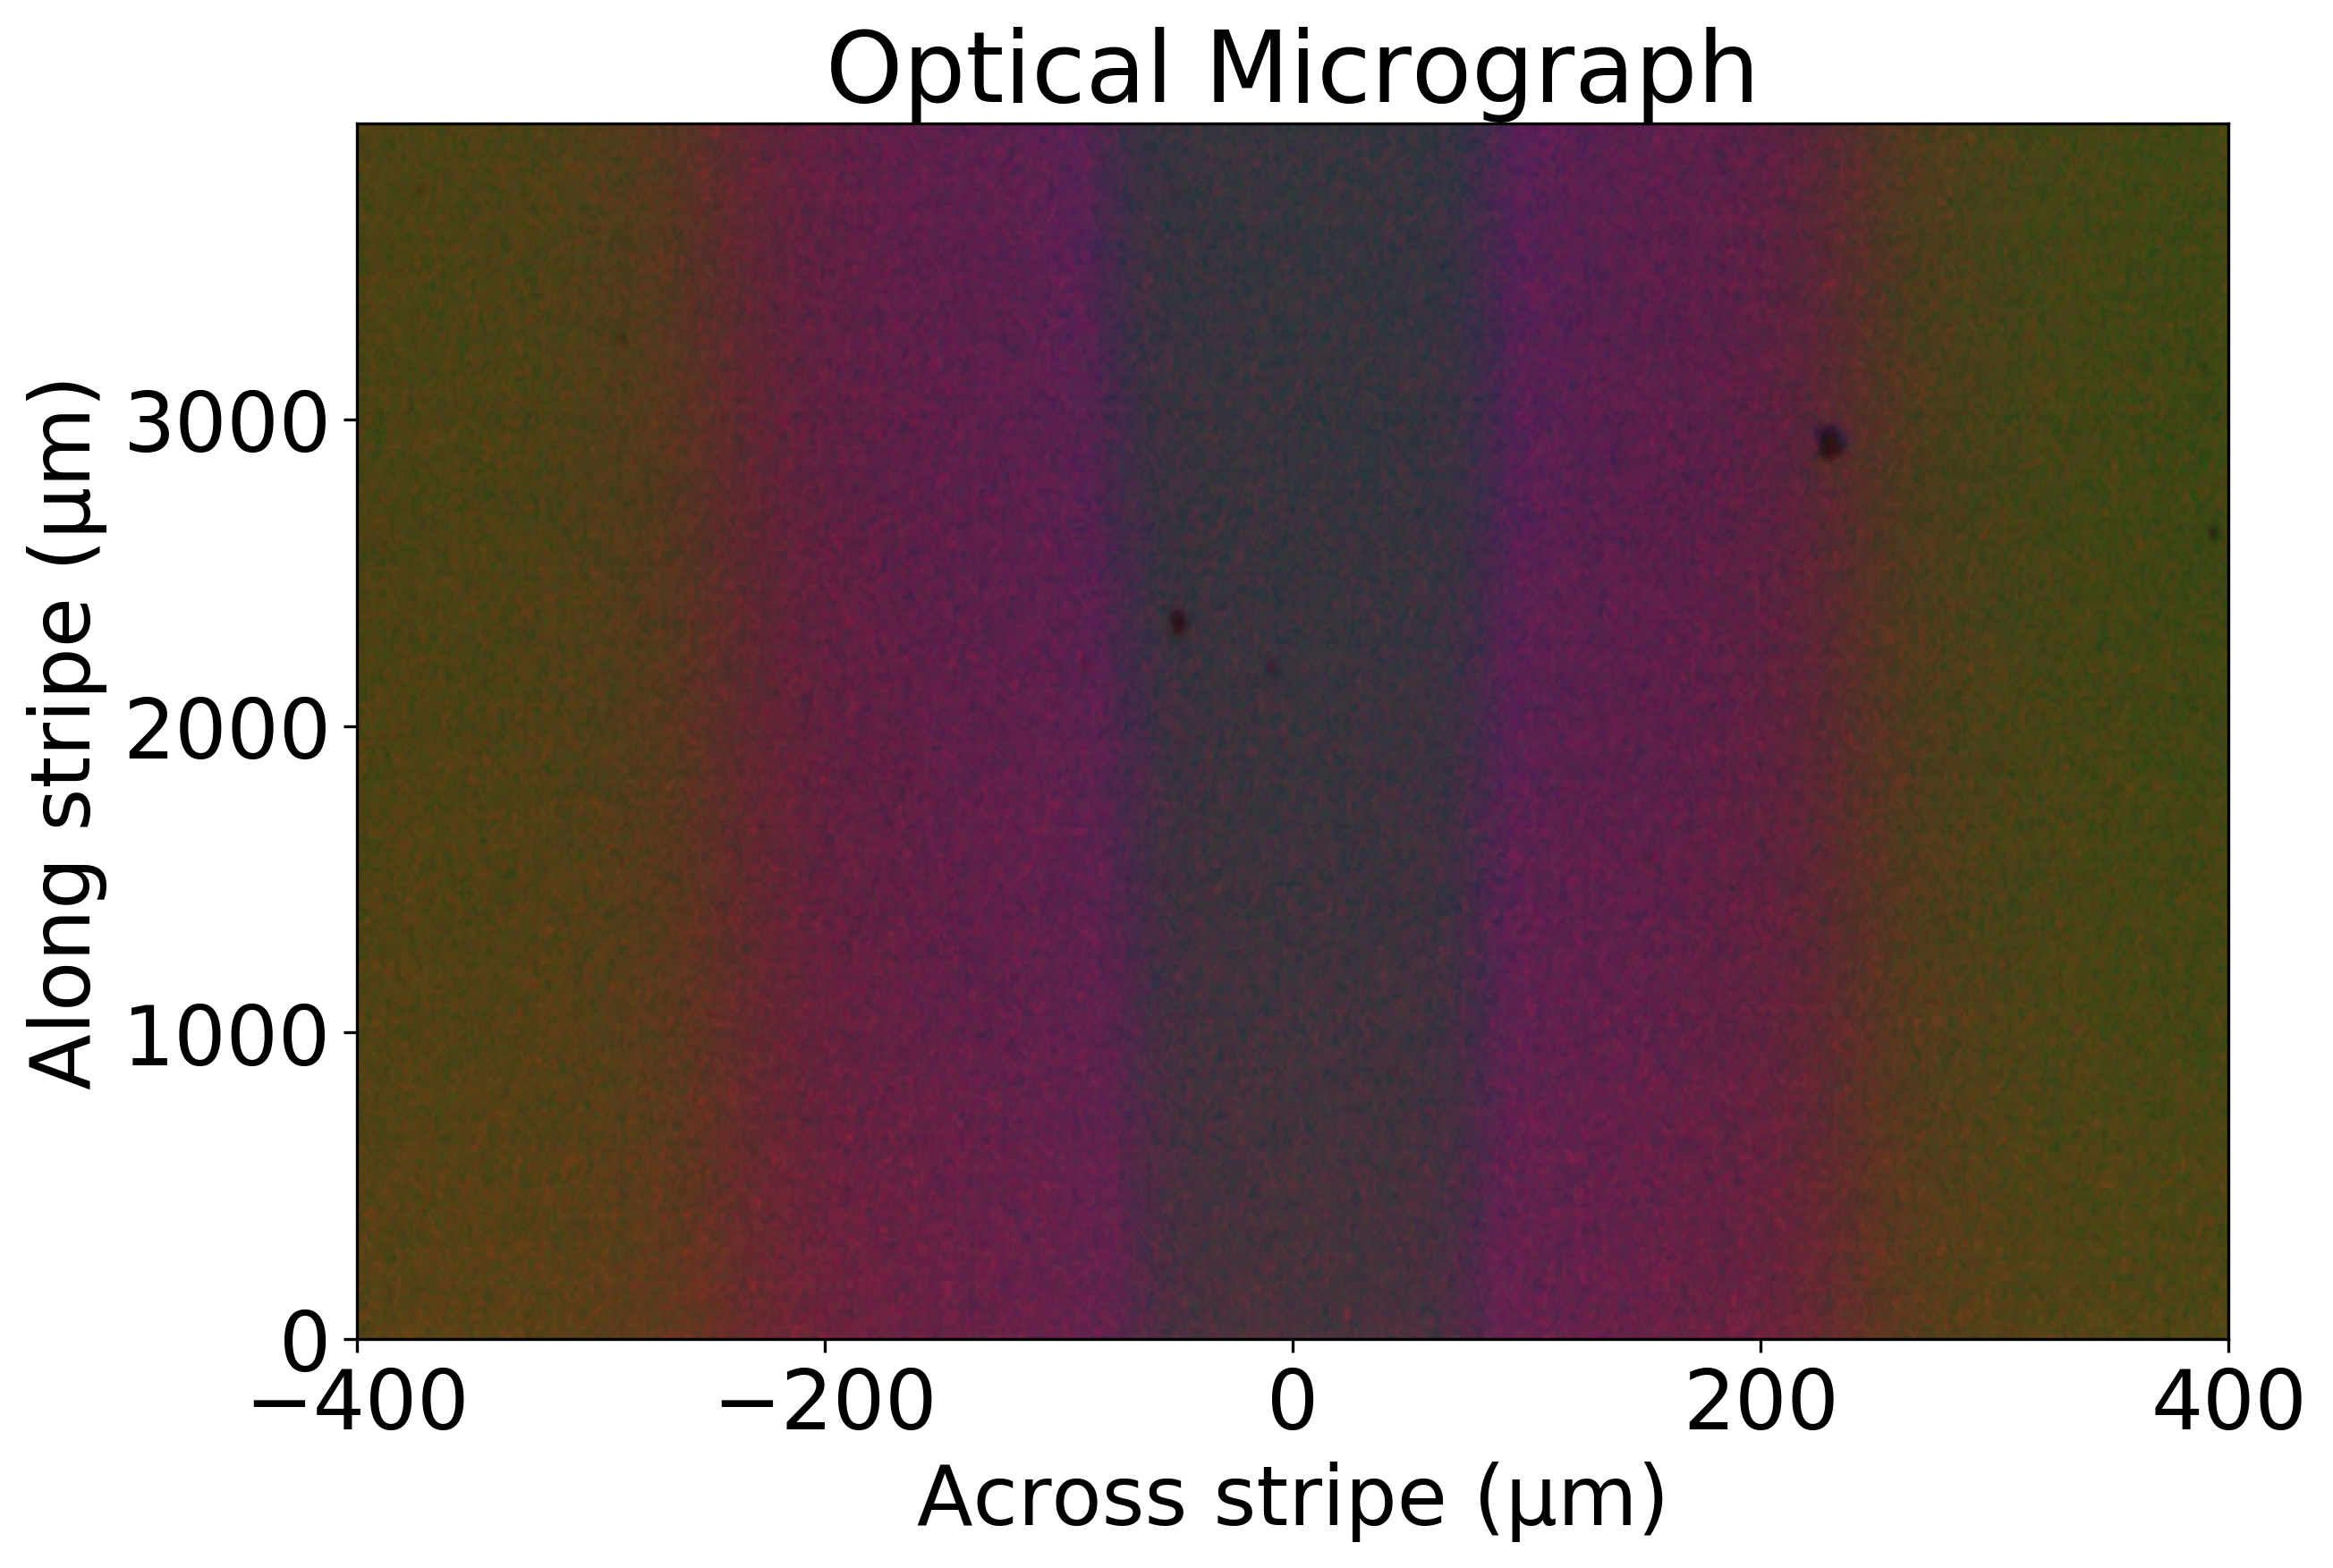

In [64]:
fig,ax=plt.subplots(1,1,dpi=300,figsize=(9,6))
im = cv2.imread(OptDict['tau_3000_T_1175']['fp'])[250:750,:,:]
ax.set_xlabel('Across stripe (\u03bcm)')
ax.set_ylabel('Along stripe (\u03bcm)')
ax.set_title('Optical Micrograph')
ax.imshow(im,aspect='auto',extent=[minx,maxx,0,im.shape[0]*ops*10])
ax.set_xlim(-400,400)
plt.savefig('/home/vandover/Desktop/08-12-2020_opt_mic.svg')

Text(0.5, 0, 'Across stripe (μm)')

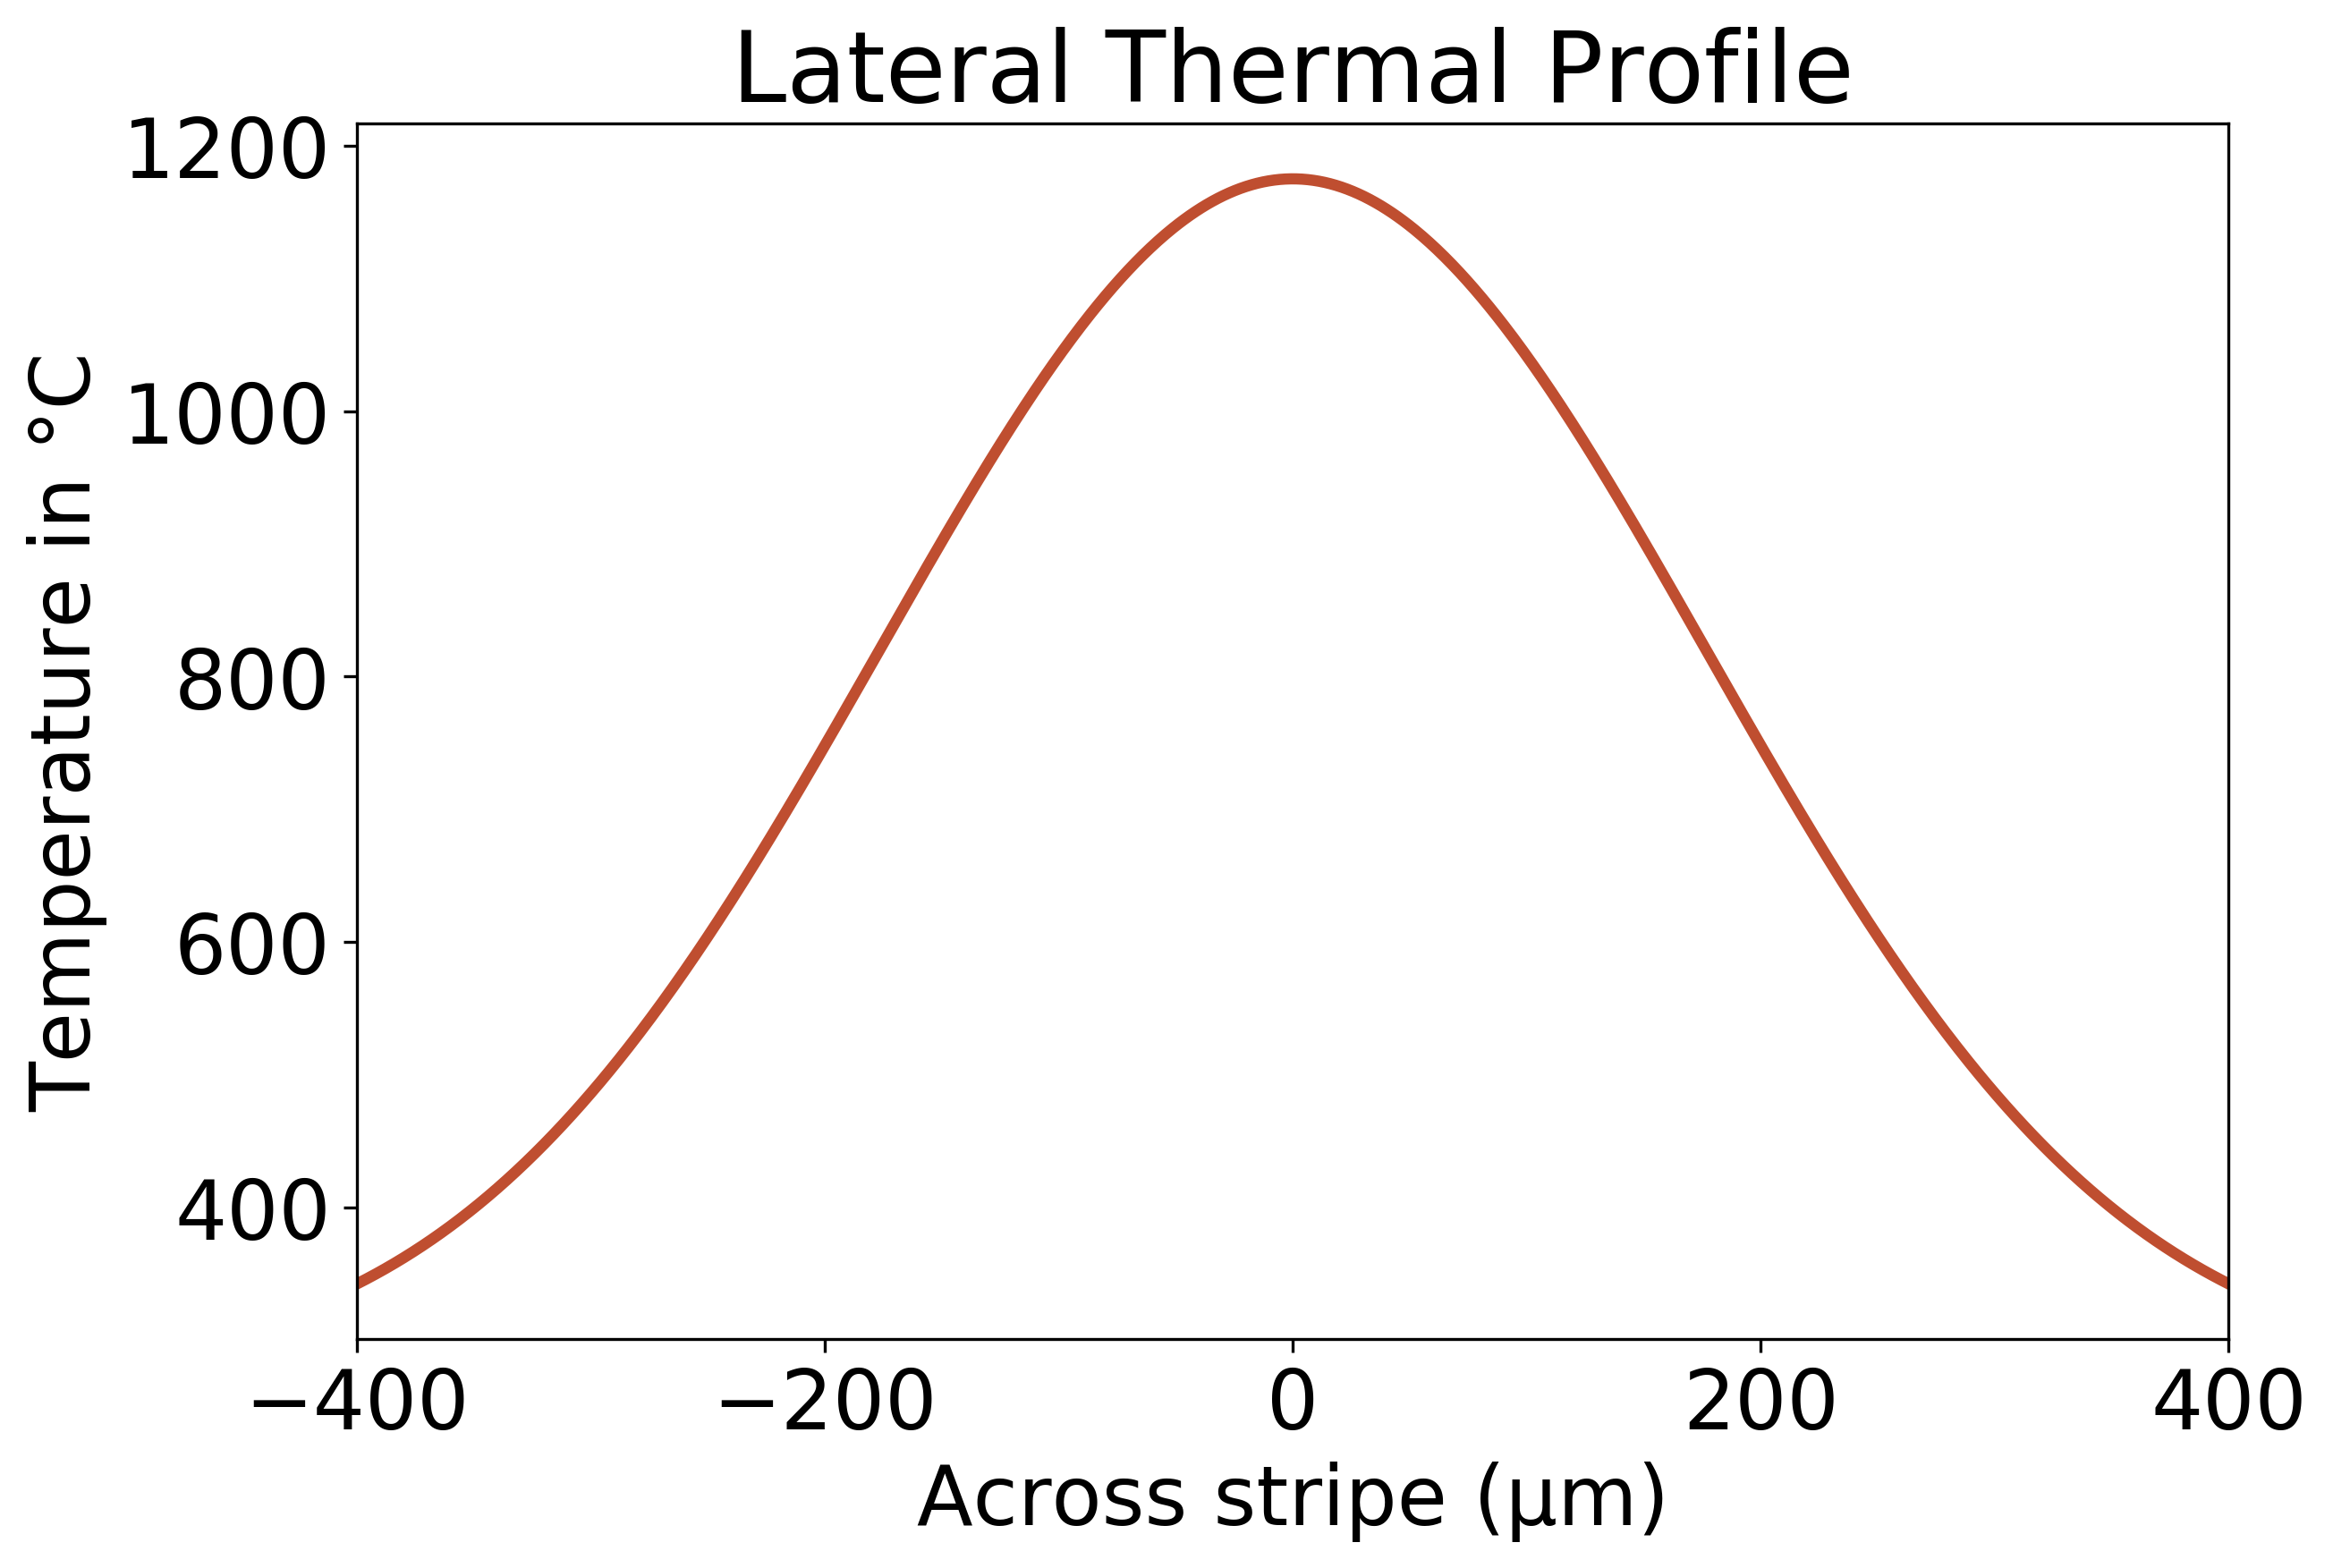

In [51]:
fig,ax=plt.subplots(1,1,dpi=300,figsize=(9,6))
colors = ['#EEC643','#BF4E30','#44BBA4','#06AED5','#ACFCD9']
# im = cv2.imread(OptDict['tau_3000_T_1175']['fp'])[250:750,:,:]
x = np.linspace(-400,400,1001)
Tprof = gaussian(x,273,902,0,300)
ax.plot(x,Tprof,c=colors[1],linewidth=3)
ax.set_xlim(-400,400)

ax.set_title('Lateral Thermal Profile')
# ax.set_xticks([])
ax.set_ylabel('Temperature in \u00B0C')
ax.set_xlabel('Across stripe (\u03bcm)')